In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [ ]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta)

        # Torch tensors
        A2 = torch.from_numpy(A_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A2, A1=A1, G1=G1, G2=G2,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0,
            stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


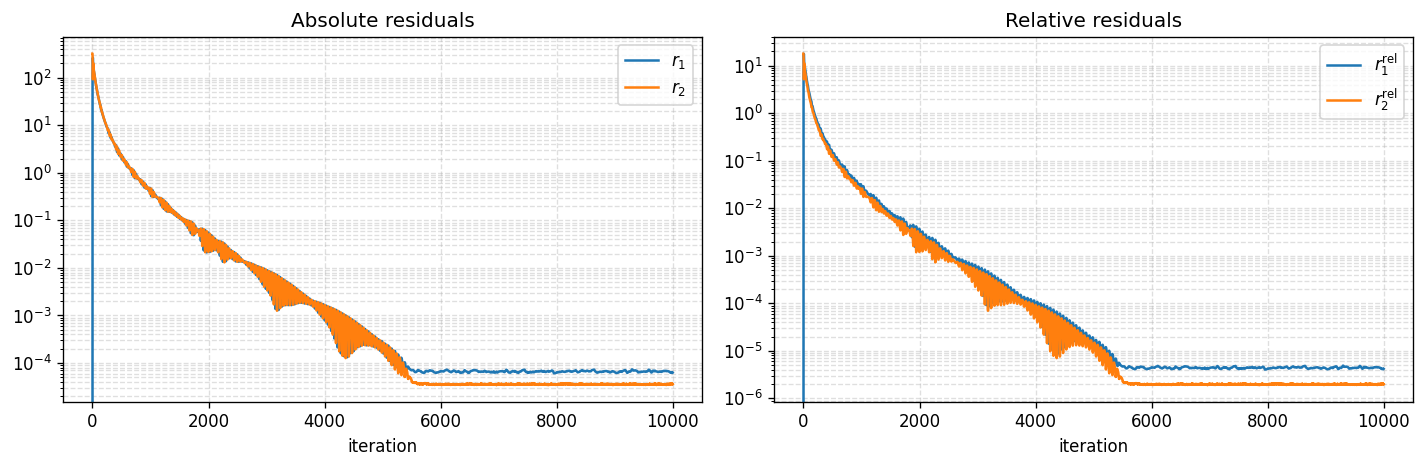

In [ ]:
plot_residuals(residuals)

## Dual feasibility checks

In [ ]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
        _, res2 = Y_dual_feasible(A1=B.to(torch.float32), A2=A.to(torch.float32), G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr", maxit=1000)
        print("residual:", res1, "residual (float32):", res2)

30x60
residual: {'res_C': 7.395190682077207e-08, 'res': 7.857218390154141e-07, 'iter': 44} residual (float32): {'res_C': 8.67251343284418e-08, 'res': 9.214343891584895e-07, 'iter': 44}
residual: {'res_C': 7.89451851648278e-08, 'res': 8.905994408309088e-07, 'iter': 48} residual (float32): {'res_C': 8.990352251990397e-08, 'res': 1.0142230059301848e-06, 'iter': 48}
residual: {'res_C': 9.08076283236199e-08, 'res': 9.86124145635685e-07, 'iter': 44} residual (float32): {'res_C': 7.91862725193172e-08, 'res': 8.599221522105521e-07, 'iter': 45}
residual: {'res_C': 6.563356741695694e-08, 'res': 7.320625900495421e-07, 'iter': 41} residual (float32): {'res_C': 8.143012289434794e-08, 'res': 9.082539444495026e-07, 'iter': 41}
residual: {'res_C': 6.931675809960154e-08, 'res': 7.456037308828981e-07, 'iter': 43} residual (float32): {'res_C': 8.404861929436909e-08, 'res': 9.040665812792113e-07, 'iter': 43}
60x30
residual: {'res_C': 6.133534039362924e-08, 'res': 7.455486354956862e-07, 'iter': 31} residua

In [ ]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
    print(f"{dual_res=}")

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
        max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0, Y0=Y0,
        stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
        diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

    # Back to NumPy for comparison
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()

dual_res={'res_C': 1.1739866715051077e-07, 'res': 4.5469746630725856e-06, 'iter': 1000}


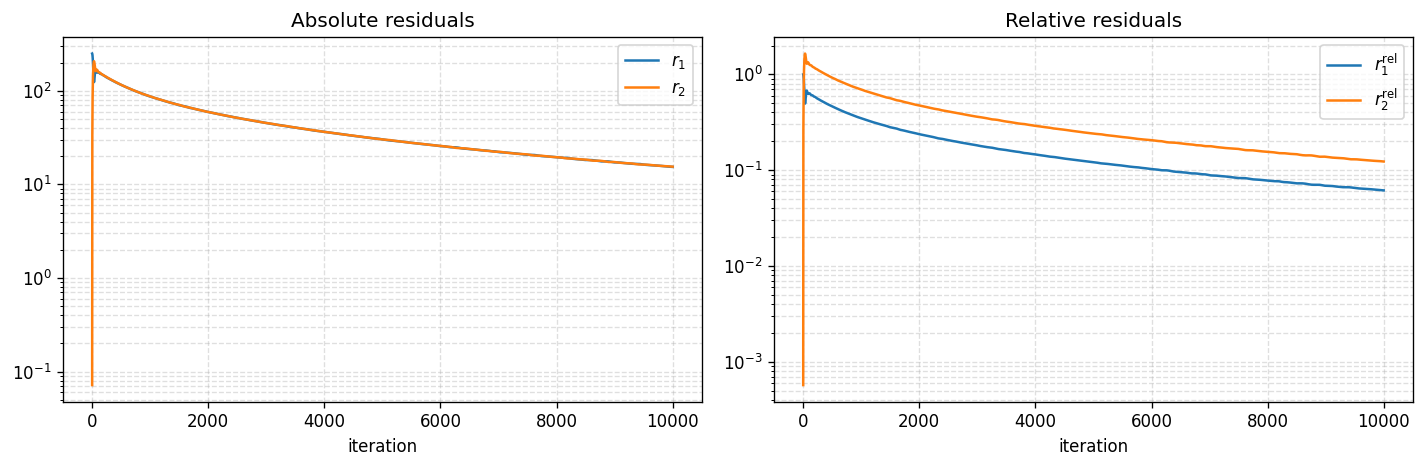

In [ ]:
plot_residuals(residuals)

In [ ]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(1.0, 1.6487374516177462, 0.49580093383789064, 0.0005706750911886623)

## reHPDHG


In [ ]:
for (m, n) in [(30, 60), (60, 30), (30, 30)]:
    for _ in range(1):
        # NumPy data for CVXPY reference
        A1_np = np.random.randn(m, n).astype(np.float64)
        A2_np = np.random.randn(m, n).astype(np.float64)
        Y0_np = np.random.randn(n, n).astype(np.float64)
        G1_np = A1_np @ Y0_np.T
        G2_np = A2_np @ Y0_np
        # Torch tensors
        A2 = torch.from_numpy(A2_np).to(torch.float64).to(device)
        A1 = torch.from_numpy(A1_np).to(torch.float64).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float64).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float64).to(device)

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta)
        Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)
        Z_star_1_torch = torch.tensor(Z0_1, dtype=A1.dtype, device=device)
        Z_star_2_torch = torch.tensor(Z0_2, dtype=A1.dtype, device=device)
        AZ = Z_star_1_torch.T @ A1 + A2.T @ Z_star_2_torch 
        print(pd_residuals_infty_ball(A=A2, B=A1, Y=Y_star_torch, Z1=Z_star_1_torch, Z2=Z_star_2_torch, 
                                      G1=G1, G2=G2, beta=beta, mu=0, abs_tol=1e-4))

        
        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A2, A1=A1, G1=G1, G2=G2,
            max_iter=7000, eps_abs=1e-8, eps_rel=1e-8,
            h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=True, enable_restart=True)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        print(pd_residuals_max_ball(A1, A2, Y_t, Z_t, G1, G2, beta, mu=0, abs_tol=1e-4))

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ A1_np + A2_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ A1_np + A2_np.T @ Z0_2)
        ) <= beta + 1e-3
print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(8.588870328801146, 0.14313352546080635, 1.7975936330156477e-13, 4.0596288799090633e-16)
(17.139965536966763, 0.2856375285299264, 0.004744539010438721, 1.0714917562497028e-05)
(1.7122348369588422e-05, 5.706878768652608e-07, 9.052279273015805e-14, 2.6745044822061547e-16)
(0.4372578949476935, 0.014573805784344683, 0.00037990291635412045, 1.1224267634131255e-06)
(3.929883581088987e-06, 1.3098302106752613e-07, 7.007484327406116e-14, 3.088851796521023e-16)
(2.964458951421401e-07, 9.880541783892948e-09, 8.876947878534072e-07, 3.912898712451785e-09)
PASSED


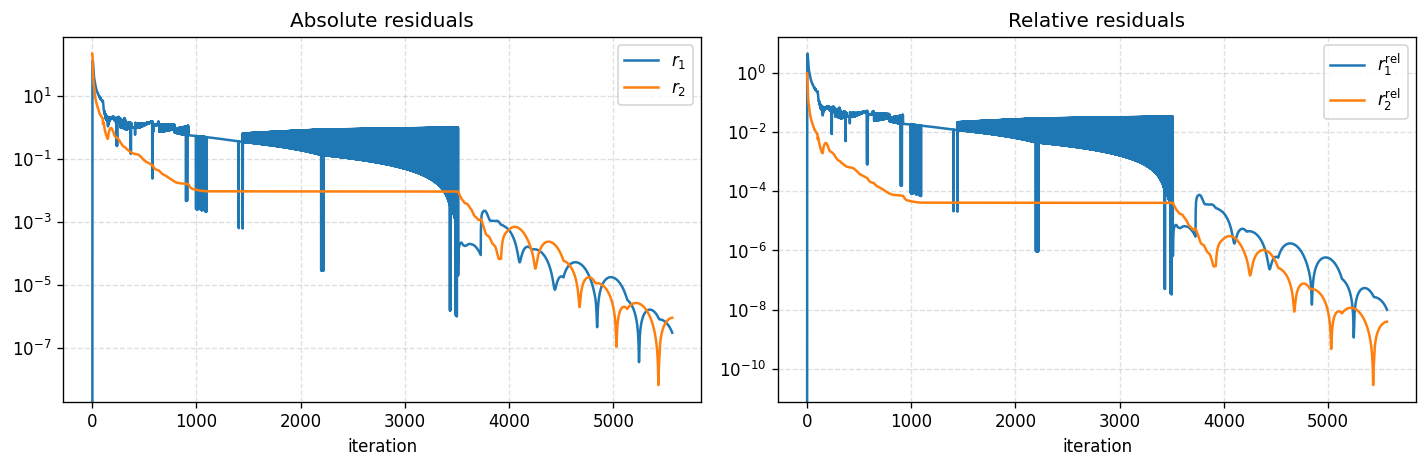

In [ ]:
plot_residuals(residuals)

## Dual feasibility checks $\|\mathcal{A}^*(Y) + G\|_F$

In [ ]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A2=A, A1=B, G1=G1, G2=G2, method="lsqr")
        _, res2 = Y_dual_feasible(A2=A.to(torch.float32), A1=B.to(torch.float32), 
                                  G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr")
        print("residual:", res1["res"], "residual (float32):", res2["res"])

30x60
residual: 8.286085842128774e-07 residual (float32): 9.55397534651787e-07
residual: 7.696962394972275e-07 residual (float32): 9.333542650350573e-07
residual: 9.864321341621387e-07 residual (float32): 8.497090360242264e-07
residual: 7.209566573535546e-07 residual (float32): 9.091289597262401e-07
residual: 9.199241895665904e-07 residual (float32): 1.0180514037995166e-06
60x30
residual: 9.432696679892136e-07 residual (float32): 9.742721965889141e-07
residual: 8.417990913964918e-07 residual (float32): 8.684972766107958e-07
residual: 8.348249943201216e-07 residual (float32): 8.510801843094607e-07
residual: 9.115409840693092e-07 residual (float32): 9.288157862632343e-07
residual: 7.020076514878777e-07 residual (float32): 7.305987872756317e-07
60x60
residual: 9.794342086657587e-07 residual (float32): 1.100482116596746e-06
residual: 9.957215135613443e-07 residual (float32): 1.1698880385185392e-06
residual: 9.62882531139757e-07 residual (float32): 1.0927931545753866e-06
residual: 9.8223643

In [ ]:
all_res = {}

settings = {"vanilla": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "diag_scaling": {"diag_scaling": True, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "equilibration": {"diag_scaling": False, "equilibration": True, "reflected_halpern":False, "enable_restart": False},
            "repdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": False},
            "ada_rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
            "ada_rehpdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
           }
m = n = 500
# NumPy data for CVXPY reference
A_np = np.random.randn(m, n)
B_np = np.random.randn(m, n)
Y0_np = np.random.randn(n, n)
G1_np = B_np @ Y0_np.T
G2_np = A_np @ Y0_np

beta = 0.5 
# Torch tensors
A = torch.from_numpy(A_np).to(torch.float32).to(device)
B = torch.from_numpy(B_np).to(torch.float32).to(device)
G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

for setting in settings:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
        max_iter=10**4, eps_abs=1e-8, eps_rel=1e-8,
        stopping=False, 
        h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
        diag_scaling=settings[setting]["diag_scaling"], 
        equilibration=settings[setting]["equilibration"],
        reflected_halpern=settings[setting]["reflected_halpern"],
        enable_restart=settings[setting]["enable_restart"],
        verbose=True
    )
    all_res[setting] = residuals

    # Back to NumPy for comparison
    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


||A||_op <= 7.0699e+02
||A||_op <= 7.0699e+02
||A||_op <= 7.0699e+02
||A||_op <= 2.7481e+02
||A||_op <= 7.0699e+02
||A||_op <= 7.0699e+02
[RESTART] iter=  99 primal_weight=3.8377e+00 r_prim=4.154e+00 r_dual=6.644e-02
[RESTART] iter= 156 primal_weight=4.9827e-01 r_prim=2.102e+00 r_dual=3.364e-02
[RESTART] iter= 245 primal_weight=1.6234e+00 r_prim=9.171e-01 r_dual=4.998e-02
[RESTART] iter= 384 primal_weight=6.8283e-01 r_prim=9.867e-01 r_dual=1.894e-02
[RESTART] iter= 601 primal_weight=9.9446e-01 r_prim=2.347e-01 r_dual=1.161e-02
[RESTART] iter= 940 primal_weight=1.0897e+00 r_prim=1.218e-01 r_dual=3.159e-03
[RESTART] iter=1470 primal_weight=9.9328e-01 r_prim=5.169e-02 r_dual=1.192e-03
[RESTART] iter=2298 primal_weight=9.6291e-01 r_prim=3.070e-02 r_dual=4.206e-04
[RESTART] iter=3592 primal_weight=1.0572e+00 r_prim=2.287e-02 r_dual=1.427e-04
[RESTART] iter=5614 primal_weight=8.1798e-01 r_prim=1.680e-02 r_dual=5.383e-05
[RESTART] iter=8773 primal_weight=7.0178e-01 r_prim=1.415e-02 r_dual=2.7

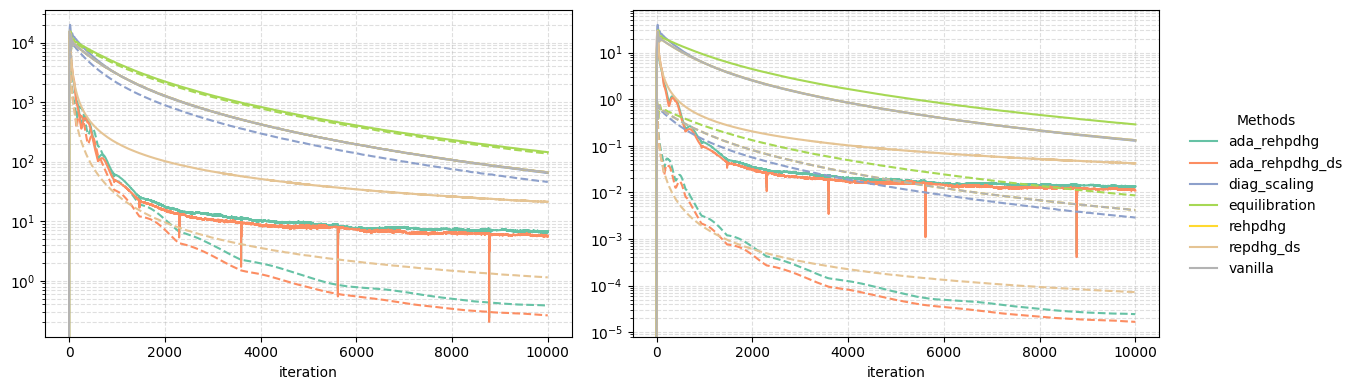

In [ ]:
plot_residuals_compare(all_res, dpi=100, dual_scale=True,
                    #    abs_ylim=(1e-7, 1e-3), rel_ylim=(1e-7, 2)
                       )